Author: Zhengyong Chen

### Final
This is the notebook that train the pharse spolier data on base bert.
Most of the model and api are come from hugging face. The code is devoloped throught the tutorial on the huggface.
https://huggingface.co/docs/transformers/tasks/question_answering

###Environment

Download the need libiary

In [6]:
!pip install transformers
!pip install bert-score
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount to the drive 

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Set the random seeds for reproducibility.

In [10]:
import torch
#print(torch.cuda.get_device_name(0))
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Set the device

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Set you model, you can use
*   bert-base-cased
*   bert-base-uncased
*   bert-large-uncased
*   bert-large-cased
*   Palak/microsoft_deberta-large_squad
*   deepset/roberta-base-squad2
*   deepset/roberta-large-squad2



In [12]:
model_name="deepset/roberta-large-squad2" 

Set which type of data you want to train
*   'phrase'
*   'passage'




In [13]:
type_of_data='phrase'

Some hyperparameter for tuning

In [49]:
max_length = 384                  # the best is 384
stride = 0                        # the best is 0
learning_rate=5e-7
weight_decay=0.01
num_train_epochs=10
model_type='bert-large-uncased'    #bert-base-uncased or bert-large-uncased             

### Data Preprocessing
Get the training file and validation_file from the local directory

In [16]:
# Set the path to your JSONL file
training_file = "/content/gdrive/MyDrive/cse_635/group_project/data/train.jsonl"
validation_file="/content/gdrive/MyDrive/cse_635/group_project/data/validation.jsonl"

A function that get the start index and end index of each answer from each content of each entry. Also, concatenate sentence array into one big string.

In [20]:
def getanswers(strs ,position):
    nums=position[0][0]
    start=0
    for i in range(len(strs)):
      if nums==i:
        start+=position[0][1]
        break
      start+=(len(strs[i])+1)
      
    return ' '.join(strs),start

A dataset class that read the file through the path, extract data from the file. It just store the question, context, answer and index of answer for each entry. The 'type' parameter is to make the class know which type of data it only load. In this case, passage or phrase.

In [21]:
import json
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, filepath, type):
        self.data = []
        self.max_length=0
        self.id=0
        with open(filepath, 'r') as f:
            for line in f:
                json_obj = json.loads(line)
                if json_obj['tags'][0]==type:
                    question = json_obj['postText'][0]
                    context = json_obj['targetParagraphs']
                    answer = json_obj['spoiler']
                    strs,start=getanswers(context,json_obj['spoilerPositions'][0])
                    context=strs
                    extracted_data = {
                        'answers': {'answer_start': [start], 'text': answer},
                        'context': context,
                        'question': question,
                        'id':str(self.id),
                    }
                    self.data.append(extracted_data)
                    self.max_length=max(self.max_length,len(context)+len(question[0]))
                self.id+=1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Load the dataset using the MyDataset just defined

In [22]:
training = MyDataset(training_file,type_of_data)
validation = MyDataset(validation_file,type_of_data)

Convet our dataset to huggingface dataset for preprocess_function() use.

In [23]:
from datasets import Dataset
dset_training = Dataset.from_list(training)
dset_training=dset_training.with_format("torch")

dset_validation = Dataset.from_list(validation)
dset_validation=dset_validation.with_format("torch")

In [24]:
for i in range(10):
  entry=training[i]
  answers=entry['answers']
  a=answers['text'][0]
  start=answers['answer_start'][0]
  end=start+len(a)
  print(a==entry['context'][start:end])


True
True
True
True
True
True
True
True
True
True


Check how the data stored 

In [25]:
validation[0]

{'answers': {'answer_start': [672], 'text': ['20%']},
 'context': 'Here’s how much you should be tipping your hairdresserMore Remembering how much you’re supposed to tip anywhere can be hard — what do current trends dictate? Is there such a thing as too much? And what if you got a discount on the service? But knowing how much to tip your hairdresser has to be one of the more confusing tip scenarios out there, especially if you get your hair done at a salon where more than one person works on your strands. Below, once and for all, is a definitive guide to tipping your hairstylist — and their assistant, shampooist, and everyone in between. Thank us later — no tip necessary. If you need a simple baseline, experts agree that tipping 20% is standard and acceptable at any hair salon. If you’re in a smaller town, 15% may be the norm. You can always ask the receptionist at your salon what’s typical, or ask on the phone when you call to make your appointment. Offering the person who shampoos yo

In [26]:
{'answers': {'answer_start': [15], 'text': ['Tom']},
 'context': 'After school, Tom is very hungry. He secretly ate Peter\'s burger.',
 'id': '3',
 'question': 'who ate Peter\'s burger?',
}

{'answers': {'answer_start': [15], 'text': ['Tom']},
 'context': "After school, Tom is very hungry. He secretly ate Peter's burger.",
 'id': '3',
 'question': "who ate Peter's burger?"}

In [27]:
answers=dset_training["answers"]+dset_validation["answers"]
answers=[entry['text'][0] for entry in answers]
m=max([len(entry) for entry in answers])

###Tokenization

Get the tokenizer from the hugging face. Used a base bert.

In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

See how to use return_overflowing_tokens parameter to chunk the long input entry.

In [29]:
context = dset_training[2]["context"]
question = dset_training[2]["question"]
inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",      
    )
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

inputs.keys()

<s>The perfect way to cook rice so that it's perfectly fluffy and NEVER sticks to the pan</s></s>Boiling rice may seem simple, but there is a very fine line between under-cooked crunchy grains and mushy over-cooked stodge. But now the perfect way to cook the rice has been shared on question-and-answer website Quora - and all it requires is one piece of equipment. Users were responding to the question 'How does one cook rice properly?' - proving that the basics are not always as simple to cook as we may think. Scroll down for video  The top voted answer for how to cook perfectly, which has been used more than 4,000 times, was refreshingly simple - but it does require some investment. Several commenters agreed that the best way to cook rice is in a rice cooker, which you can pick up from most high street stores for between £15 and £20. Cliff Chang wrote: 'Seriously, it's so much easier than any other method I've tried. 'Take your rice, wash it a bit - not too much - add enough water so t

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

The mean: of the data is 561
The median: of the data is 410


<BarContainer object of 763 artists>

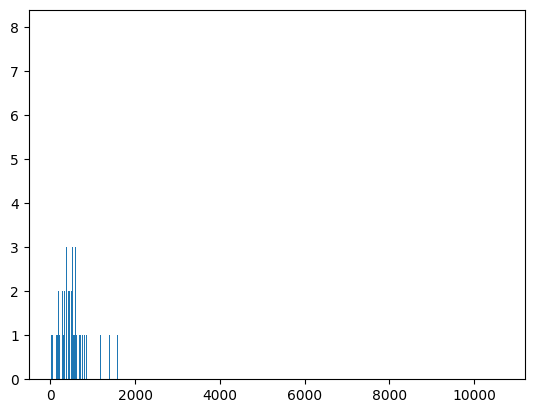

In [30]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy

inputs = tokenizer(
        dset_training["context"],
        dset_training["question"],
        max_length=500000,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='do_not_pad',      
    )

dis=[len(entry) for entry in inputs["input_ids"]]
mean=int(numpy.mean(dis))
median=int(numpy.median(dis))
print("The mean: of the data is "+str(mean))
print("The median: of the data is "+str(median))
data=Counter(dis)
plt.bar(data.keys(), data.values())

A preprocess function for training. Tokenize each data first. And then create the start and end index of the answer in the context for loss function. If no answer, the start and end index will be zero.



In [31]:
def preprocess_function_training(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Use map function and preprocess_function_training as parameter to tokenize our training data for bert used.

In [32]:
tokenized_training = dset_training.map(preprocess_function_training, batched=True,remove_columns=dset_training.column_names)
tokenized_training

Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 2702
})

A preprocess function for validation. Similiar to preprocess_function_training. Add a example_id that used for evaluation

In [33]:
def preprocess_function_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids

    offset_mapping = inputs["offset_mapping"]
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

Use map function and preprocess_function_validation() as parameter to tokenize our validation data for bert used.

In [34]:
tokenized_validation = dset_validation.map(preprocess_function_validation, batched=True,remove_columns=dset_validation.column_names)

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

###Training

Setting the gpu device, model and output directory.

You can save your trained model to your own path by setting variable output_dir.



In [38]:
from transformers import BertForQuestionAnswering,DebertaForQuestionAnswering,RobertaForQuestionAnswering

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = RobertaForQuestionAnswering.from_pretrained(model_name).to(device)
output_dir="/content/gdrive/MyDrive/cse_635/group_project/code/milestone3/"+model_name+"_"+type_of_data

A function that for evaluation use. For each entry, get the 20 best answer according to the logit and then choose the best one that has the logit score.
Then use the evalutation function above to calcualte the scores.

Setting some hyper paramater for fine tuning

In [39]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    fp16=True,
)

Start training

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_training,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


###Evaluation

A function that for evaluation use. For each entry, get the 20 best answer according to the logit and then choose the best one that has the logit score. Then use the evalutation function above to calcualte the scores.

Create bleu, meteor, bertscore class by using huggingface interface



In [41]:
import evaluate
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

def my_bleu(hyp_list, ref_list):
    #this weight is used from the paper
    def make_score(trut, predi):
        if len(trut) > 3 and len(predi) > 3:
            weights = (1./4., 1./4., 1./4., 1./4.)
        elif len(trut) > 2 and len(predi) > 2:
            weights = (1./3., 1./3., 1./3.)
        elif len(trut) > 1 and len(predi) > 1:
            weights = (1./2., 1./2.)
        else:
            weights = (1., 0.)

        if (len(weights) == 4) and (len(trut) < 4 or len(predi) < 4):
            print(trut)
            print(predi)
            print(weights)
            print('\n')

        smoothing_fn = SmoothingFunction().method3
        return sentence_bleu([trut], predi, weights=weights, smoothing_function=smoothing_fn)
    
    score=0
    size=len(hyp_list)
    for i in range(size):
      score+=make_score(ref_list[i],hyp_list[i])

    return score/size

def my_meteor(hyp_list, ref_list):
    hyp_tokens_list = [hyp.split() for hyp in hyp_list]
    ref_tokens_list = [ref.split() for ref in ref_list]

    hyp_unigrams = [word for hyp in hyp_tokens_list for word in hyp]
    ref_unigrams = [word for ref in ref_tokens_list for word in ref]
    hyp_unigram_counts = Counter(hyp_unigrams)
    ref_unigram_counts = Counter(ref_unigrams)
    overlap_count = sum((hyp_unigram_counts & ref_unigram_counts).values())

    hyp_count = sum(hyp_unigram_counts.values())
    ref_count = sum(ref_unigram_counts.values())
    precision = overlap_count / hyp_count if hyp_count > 0 else 0
    recall = overlap_count / ref_count if ref_count > 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

bleu = evaluate.load('bleu')
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [42]:
from tqdm.auto import tqdm
import collections
import numpy as np
n_best = 20
max_answer_length=8 

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []
        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)
        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(best_answer["text"])
        else:
            predicted_answers.append("")
    
    theoretical_answers = [ex["answers"]["text"][0] for ex in examples]
    
    return predicted_answers, theoretical_answers

As we can see, the validation loss increase at epoch 3. Therefore, we will use the model checkpoint at eopch 2 for our evaluation.

In [43]:
from transformers import BertForQuestionAnswering,DebertaForQuestionAnswering,RobertaForQuestionAnswering
from transformers import Trainer, AutoTokenizer
model_dir="/content/gdrive/MyDrive/cse_635/group_project/code/milestone3/tuned_models/deepset/roberta-large-squad2_phrase"
best_checkpoint = RobertaForQuestionAnswering.from_pretrained(model_dir).to(device)
checkpoint_tokenizer=AutoTokenizer.from_pretrained(model_dir)
trainer_best_checkpoint = Trainer(
    model=best_checkpoint,
    args=args,
    train_dataset=tokenized_training,
    eval_dataset=tokenized_validation,
    tokenizer=checkpoint_tokenizer,
)


Start evaluation

In [44]:
predictions, _, _ = trainer_best_checkpoint.predict(tokenized_validation)
start_logits, end_logits = predictions
predicted_answers, theoretical_answers= compute_metrics(start_logits, end_logits, tokenized_validation, dset_validation)

print(predicted_answers[0:20])
print(theoretical_answers[0:20])

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/335 [00:00<?, ?it/s]

['20%', 'Sprite', 'Garbanzo Beans', 'Anthony Bourdain', 'Dibrom', 'They don’t fart', '9:30 a.m', 'bricking iPad Pros', 'Mike Rounds', 'reduced fat sour cream', 'Edward Gorey', "Rag & Bone's DIY Project", 'pixie cut', 'southern flying squirrel', "Hope's antique cabinet", 'August 6th', 'perfectly average', 'I need some alone time."', 'The Arizona Republic', 'is an indication that our days are numbered']
['20%', 'Sprite', 'Smoky Paprika-Baked Garbanzo Beans', 'Anthony Bourdain', 'Dibrom', 'They don’t fart', 'starts later', 'bricking iPad Pros', 'Stace Nelson', 'reduced fat sour cream', 'Edward Gorey', 'Rag & Bone', 'pixie cut', 'southern flying squirrel', "Hope's antique cabinet", 'August 6th', 'perfectly average', '"but"', 'The Arizona Republic', 'apocalyptic omen']


In [50]:
bleu_score1=bleu.compute(predictions=predicted_answers, references=theoretical_answers)
meteor_score1=meteor.compute(predictions=predicted_answers, references=theoretical_answers,gamma=0)
bleu_score2=my_bleu(predicted_answers, theoretical_answers)
meteor_score2 = my_meteor(predicted_answers, theoretical_answers)
bertscore_score=bertscore.compute(predictions=predicted_answers, references=theoretical_answers,lang="en",model_type=model_type)
print(bleu_score2)
print(meteor_score1)
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print("bert score: "+str(cal_average(bertscore_score['f1'])))

0.7109999822355728
{'meteor': 0.7400159427948624}
bert score: 0.8414905958211244
